<a href="https://colab.research.google.com/github/Roarou/Computational-control/blob/main/COCO_Tutorial_LQR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from typing import Tuple

Define the system matrices

In [2]:
n_x, n_u = 2, 2

A = np.array([[2, 0],[0, 3]])
B = np.eye(n_x)


Q = np.array([[1, 0], [0, 0]])
R = np.eye(n_u)

initial_condition = np.random.randn(n_x)

Simulate system with a random initial condition and no input ($K=0$): Clearly the origin of the system is unstable. 


[1.56089987 0.91200274]


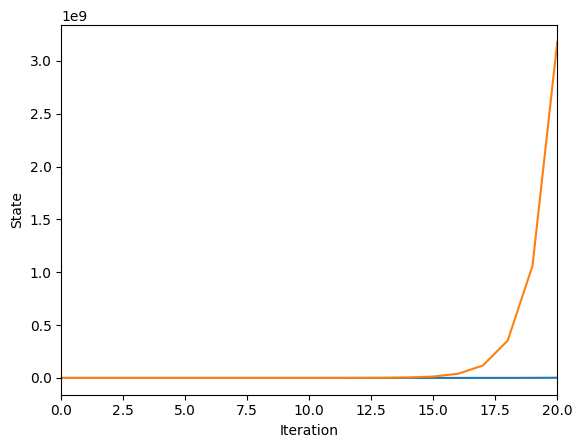

The cost is 3571812477186.243.


In [6]:
def simulate(horizon: int, initial_condition: np.ndarray, control_gain: np.ndarray or None=None) -> Tuple[np.ndarray, float]:
  if control_gain is None:
    control_gain = np.zeros((n_x, n_u))
  assert control_gain.shape == (n_x, n_u), 'Check shape of the control gain.'
  assert initial_condition.shape == (n_x, ), 'Check shape of the initial condition.'
  x = np.nan*np.ones((n_x, horizon+1)) 
  x[:, 0] = initial_condition
  print(x[:, 0])
  cost = 0.0
  for t in range(horizon):
    u_t = np.matmul(control_gain, x[:, t])
    x[:, t+1] = np.matmul(A, x[:, t]) + np.matmul(B, u_t)
    cost += np.matmul(x[:, t].T, np.matmul(Q, x[:, t])) + np.matmul(u_t.T, np.matmul(R, u_t))
  cost += np.matmul(x[:, -1].T, np.matmul(Q, x[:, -1]))
  return x, float(cost)

def plot_trajectory(data:np.ndarray) -> None:
  # Plot
  plt.plot(x.T)
  plt.xlabel('Iteration')
  plt.ylabel('State')
  plt.xlim((0, x.shape[1]-1))
  plt.show()

x, cost = simulate(horizon=20, initial_condition=initial_condition, control_gain=None)

plot_trajectory(x)

print('The cost is ' + str(cost) + '.')


Compute LQR iteration: The LQR controller does not stabilize the syste,

[1.56089987 0.91200274]


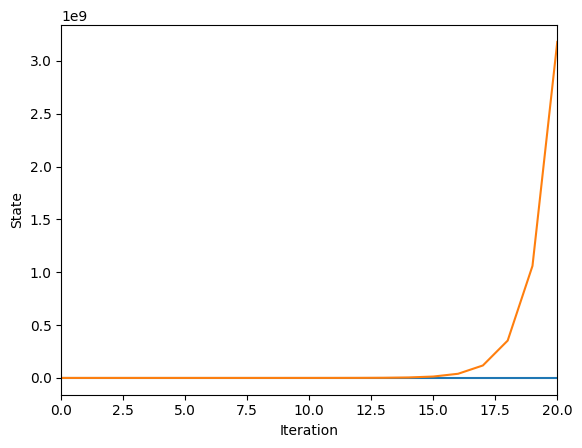

The cost is 10.32079157283507.


In [8]:
def P_new_lqr(P_old: np.ndarray) -> np.ndarray:
  P = Q + \
    np.matmul(np.matmul(A.T, P_old), A) - \
    np.matmul(np.matmul(np.matmul(np.matmul(A.T, P_old), B),
                        np.linalg.inv(R + np.matmul(np.matmul(B.T, P_old), B))),
              np.matmul(B.T, np.matmul(P_old, A)))
  return P

def get_controller_from_P(P: np.ndarray) -> np.ndarray:
  K = - np.matmul(np.linalg.inv(R + np.matmul(np.matmul(B.T, P), B)),
                  np.matmul(B.T, np.matmul(P, A)))
  return K
  
def lqr_iteration(initial_condition: np.ndarray, iterations: int) -> Tuple[np.ndarray, np.ndarray]:
  assert initial_condition.shape == (n_x, n_x), 'Check shape of the initial condition.'
  P = initial_condition
  for _ in range(iterations):
    P = P_new_lqr(P)
  return (P, get_controller_from_P(P))

P_inf, K_inf = lqr_iteration(initial_condition=np.zeros((n_x, n_x)), iterations=100)

x, cost = simulate(horizon=20, initial_condition=initial_condition, control_gain=K_inf)

plot_trajectory(x)

print('The cost is ' + str(cost) + '.')


Solve now the DARE.


In [9]:
P_inf_are = la.solve_discrete_are(a=A, b=B, q=Q, r=R)
K_inf_are = get_controller_from_P(P_inf_are)

P_inf_nonzero, K_inf_nonzero = lqr_iteration(initial_condition=np.eye(n_x), iterations=100)

print('P_inf via ARE:')
print(P_inf_are)
print(K_inf_are)

print('P_inf via iterations (non-zero initial condition):')
print(P_inf_nonzero)

print('P_inf via iterations (zero initial condition):')
print(P_inf)


P_inf via ARE:
[[4.23606798 0.        ]
 [0.         8.        ]]
[[-1.61803399 -0.        ]
 [-0.         -2.66666667]]
P_inf via iterations (non-zero initial condition):
[[4.23606798 0.        ]
 [0.         8.        ]]
P_inf via iterations (zero initial condition):
[[4.23606798 0.        ]
 [0.         0.        ]]


Show now that the new controller indeed stabilizes the system. 

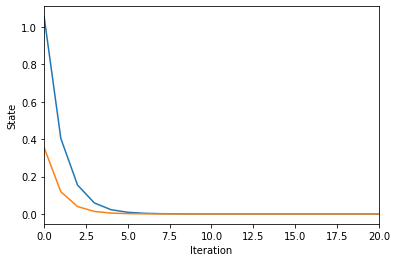

The cost is 5.742866979658208.


In [ ]:
x, cost = simulate(horizon=20, initial_condition=initial_condition, control_gain=K_inf_are)

plot_trajectory(x)

print('The cost is ' + str(cost) + '.')

Finally, any other stabilizing controller yields larger cost. We use that the system is decoupled and so $K$ is diagonal. 

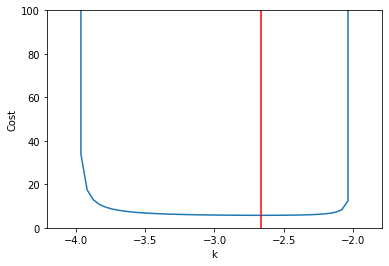

In [ ]:
k_vec = np.linspace(start=-1-A[1, 1]-0.1, stop=1-A[1, 1]+0.1, num=50)
cost_vec = []

for k in k_vec:  # range of controllers which are stabilizing
  _, cost = simulate(horizon=2000, initial_condition=initial_condition, control_gain=np.array([[K_inf_are[0, 0],0],[0, k]]))
  cost_vec.append(cost)

plt.plot(k_vec, cost_vec)
plt.axvline(x=K_inf_are[1, 1], color='red')
plt.ylabel('Cost')
plt.xlabel('k')
plt.ylim((0, 20))
plt.show()